In [2]:
import jax
import jax.numpy as jnp
from jax.numpy.linalg import lstsq
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch
from torch.nn.utils import parameters_to_vector, vector_to_parameters

import time
import pandas as pd
from scipy.integrate import quad
from copy import copy
import sys
import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('experiments'), '..')))

from tedeous.data import Domain, Conditions, Equation
from tedeous.model import Model
from tedeous.callbacks import early_stopping
from tedeous.optimizers.optimizer import Optimizer
from tedeous.eval import integration

iteration=  0
step=  9.313225746154785e-10
loss= 0.1799988865890384


C:\Users\user\AppData\Local\Temp\ipykernel_10620\2456747554.py:72: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return -quad(integrand1, -np.inf, np.inf, args=(x, t))[0] / quad(integrand2, -np.inf, np.inf, args=(x, t))[
C:\Users\user\AppData\Local\Temp\ipykernel_10620\2456747554.py:72: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return -quad(integrand1, -np.inf, np.inf, args=(x, t))[0] / quad(integrand2, -np.inf, np.inf, args=(x, t))[


l2_norm= 0.5679590889545845


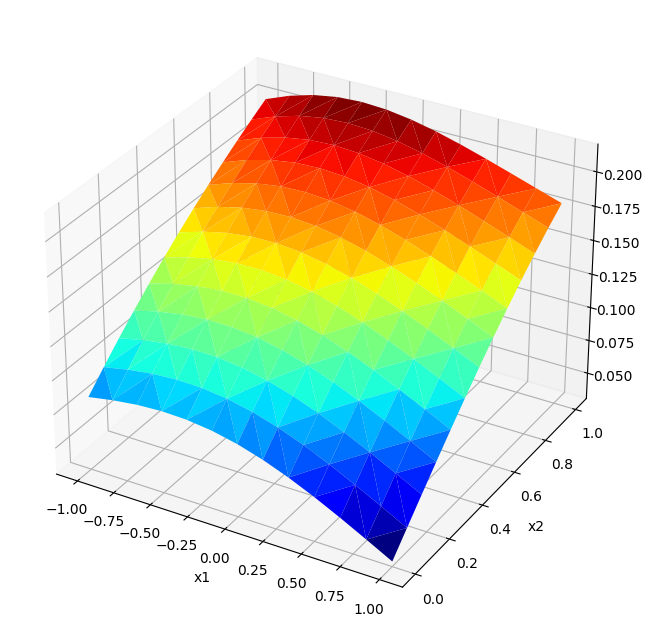

iteration=  10
step=  9.313225746154785e-10
loss= 0.1799988904781388
l2_norm= 0.5679590991586355


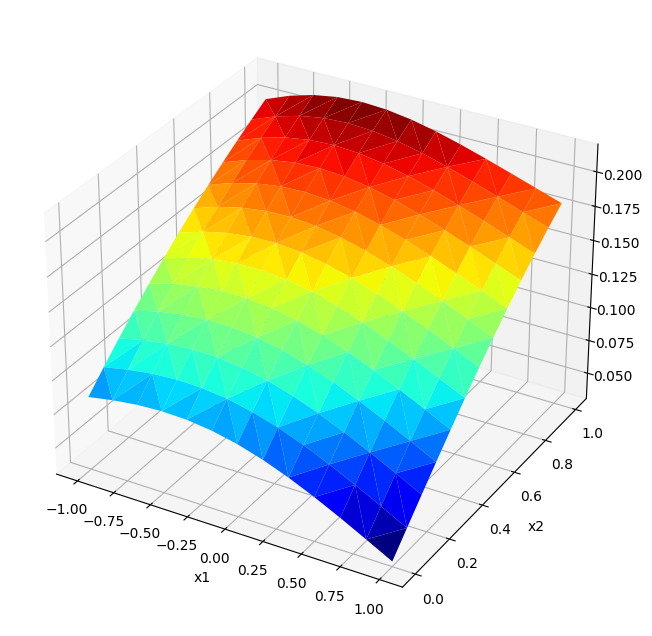

iteration=  20
step=  9.313225746154785e-10
loss= 0.17999889379254738
l2_norm= 0.5679591084274751


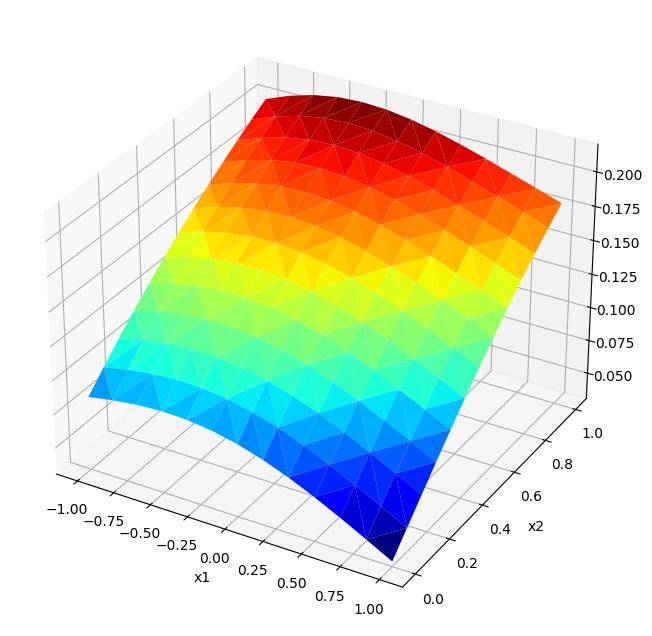

iteration=  30
step=  1.862645149230957e-09
loss= 0.17336720594372643
l2_norm= 0.5736772102708637


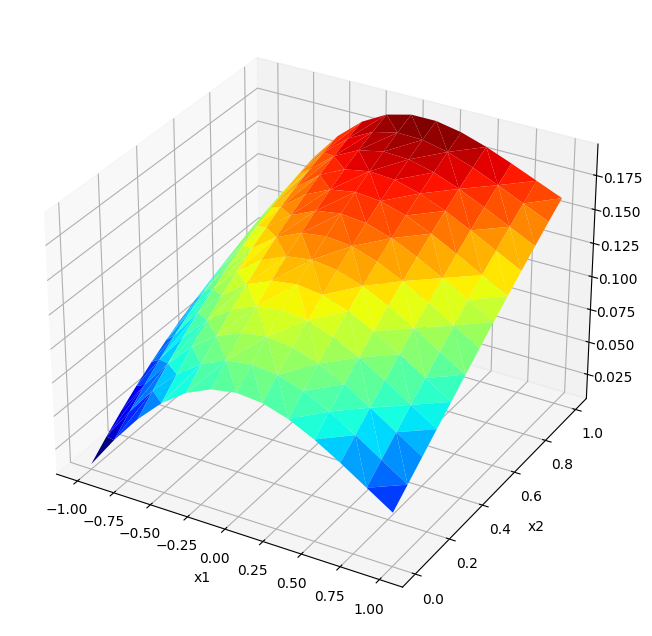

iteration=  40
step=  1.862645149230957e-09
loss= 0.1733671996810305
l2_norm= 0.5736771950517701


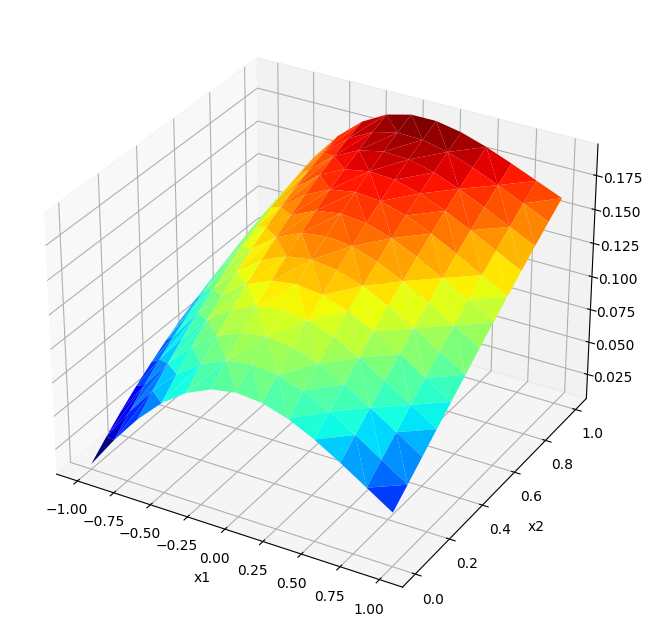

iteration=  50
step=  1.862645149230957e-09
loss= 0.17336719385256572
l2_norm= 0.5736771806680493


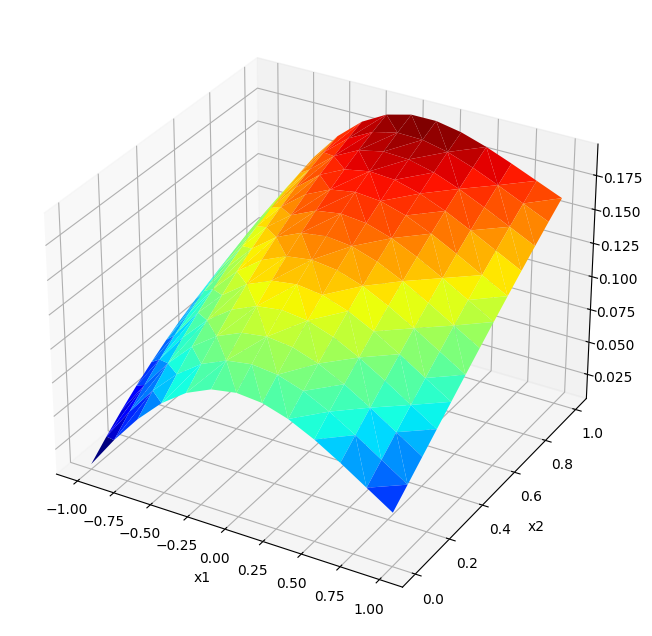

iteration=  60
step=  1.862645149230957e-09
loss= 0.1733671883268209
l2_norm= 0.5736771666370342


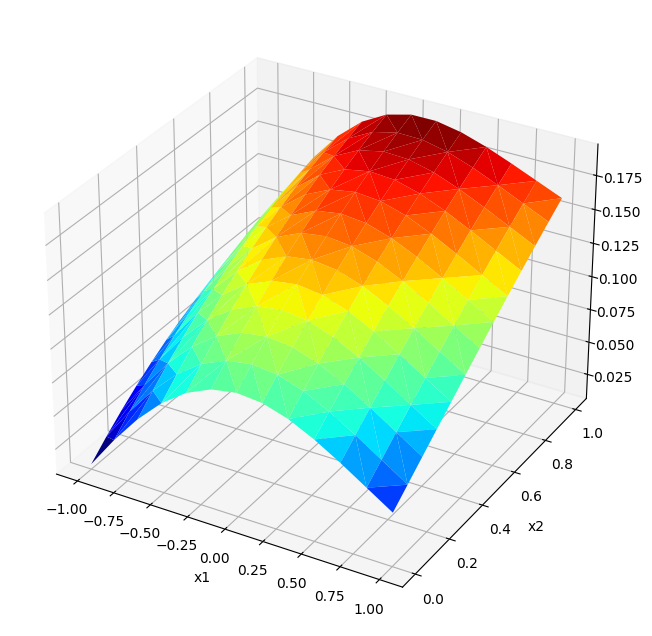

iteration=  70
step=  9.313225746154785e-10
loss= 0.17336718339720528
l2_norm= 0.573677153576524


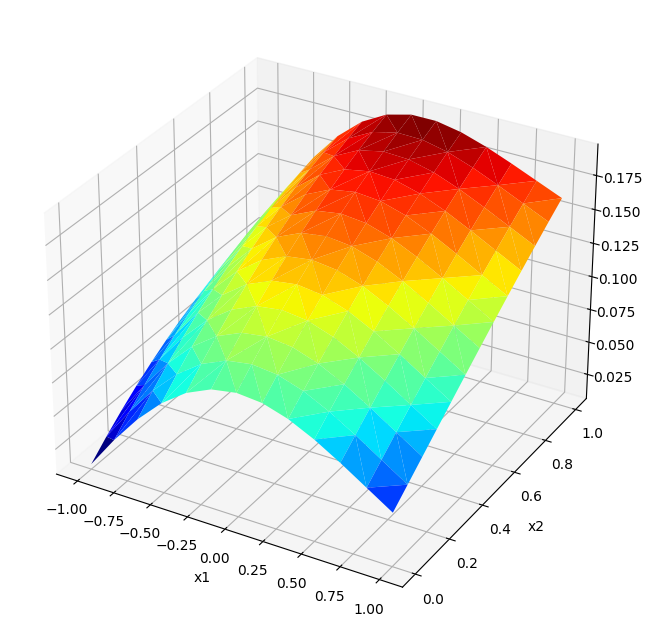

iteration=  80
step=  1.862645149230957e-09
loss= 0.17336717855602846
l2_norm= 0.5736771407963756


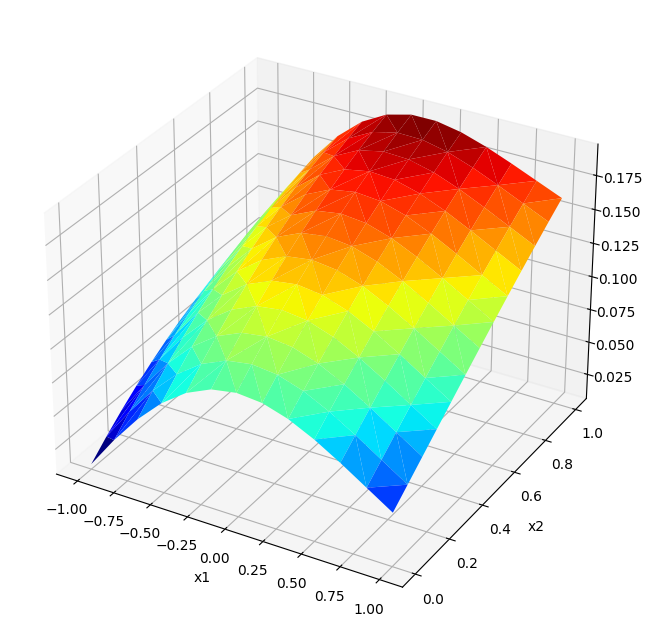

iteration=  90
step=  1.862645149230957e-09
loss= 0.1733671738570006
l2_norm= 0.5736771289915444


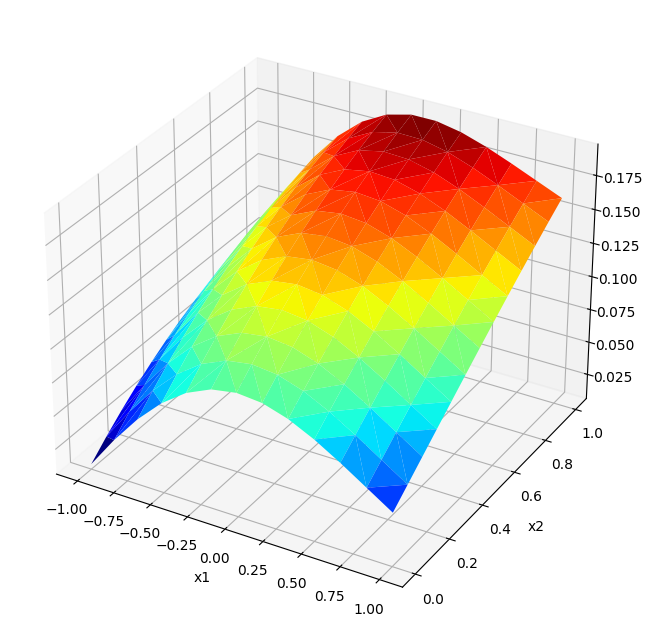

iteration=  100
step=  1.862645149230957e-09
loss= 0.1733671693720487
l2_norm= 0.573677117591042


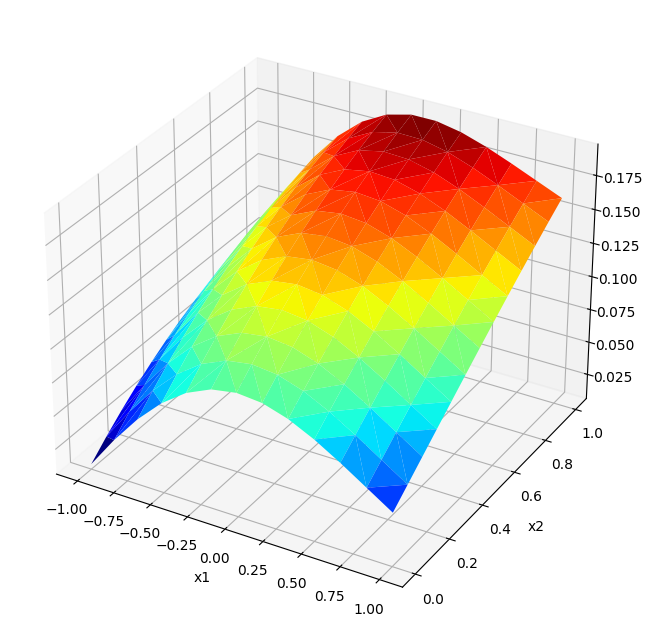

iteration=  110
step=  9.313225746154785e-10
loss= 0.17336716526359763
l2_norm= 0.5736771082163388


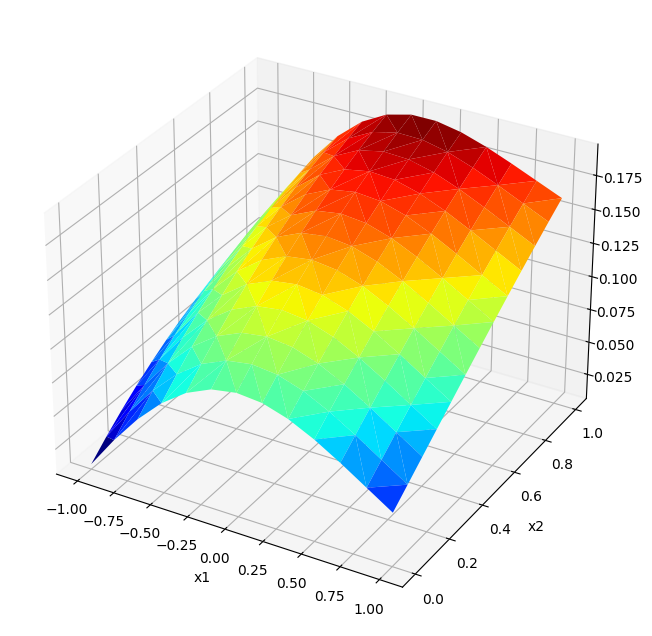

iteration=  120
step=  9.313225746154785e-10
loss= 0.17336716121933732
l2_norm= 0.5736770992449302


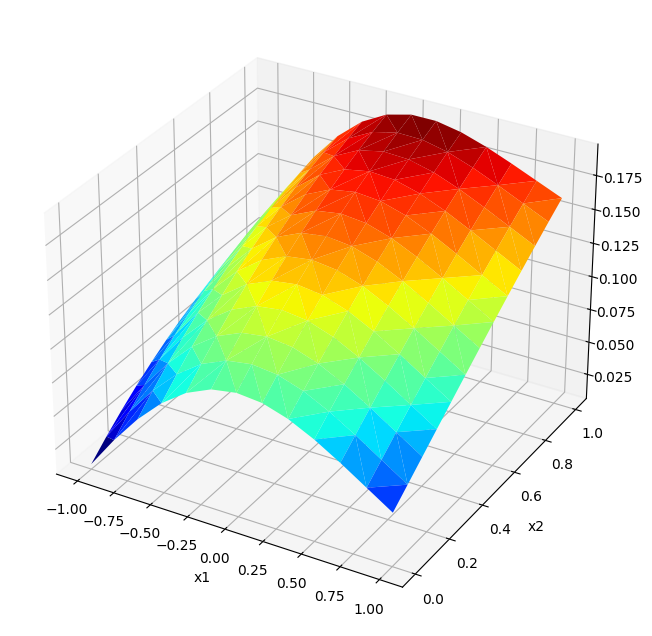

iteration=  130
step=  9.313225746154785e-10
loss= 0.17336715706007091
l2_norm= 0.573677089723132


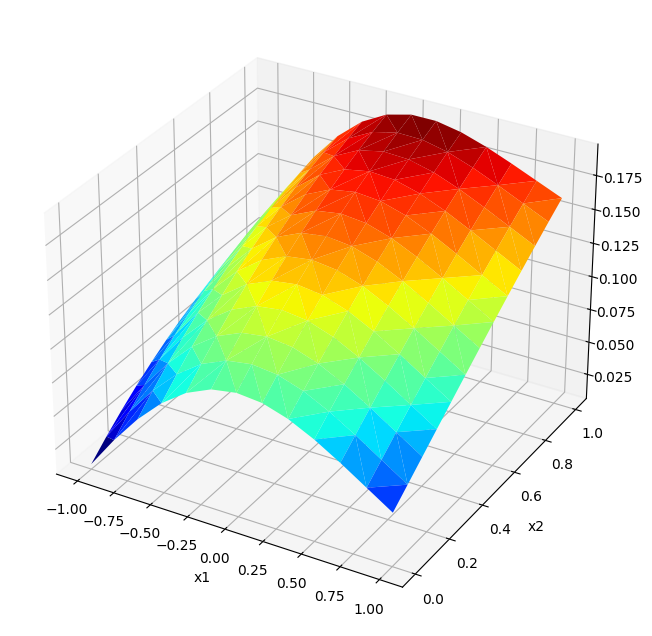

KeyboardInterrupt: 

In [4]:

torch.set_default_device('cuda')
torch.set_default_dtype(torch.float64)
jax.config.update("jax_enable_x64", True)

def replace_none_with_zero(tuple_data):
    if isinstance(tuple_data, torch.Tensor):
        tuple_data[tuple_data == None] = 0
    elif tuple_data is None:
        tuple_data = torch.tensor([0.])
    elif isinstance(tuple_data, tuple):
        new_tuple = tuple(replace_none_with_zero(item) for item in tuple_data)
        return new_tuple
    return tuple_data

def gramian(net, residuals):
        # Compute the jacobian on batched data
    def jacobian():
        jac = []
        loss = residuals
        for l in loss:
            j = torch.autograd.grad(l, net.parameters(), retain_graph=True, allow_unused=True)
            j = replace_none_with_zero(j)
            j = parameters_to_vector(j).reshape(1, -1)
            jac.append(j.T @ j)
        return torch.stack(jac, dim=0) #torch.cat(jac)

    J = jacobian()
    return  torch.mean(J, dim=0) #1.0 / len(residuals) * J.T @ J

def grid_line_search_factory(loss, steps):

    def loss_at_step(step, model, tangent_params):
        params = parameters_to_vector(model.parameters())
        new_params = params - step*tangent_params
        vector_to_parameters(new_params, model.parameters())
        loss_val, _ = loss()
        vector_to_parameters(params, model.parameters())
        return loss_val

    def grid_line_search_update(model, tangent_params):

        losses = []
        for step in steps:
            losses.append(loss_at_step(step, model, tangent_params).reshape(1))
        losses = torch.cat(losses)
        step_size = steps[torch.argmin(losses)]

        params = parameters_to_vector(model.parameters())
        new_params = params - step_size*tangent_params
        vector_to_parameters(new_params, model.parameters())

        return step_size

    return grid_line_search_update

def exact(grid):
    mu = 0.01 / np.pi

    def f(y):
        return np.exp(-np.cos(np.pi * y) / (2 * np.pi * mu))

    def integrand1(m, x, t):
        return np.sin(np.pi * (x - m)) * f(x - m) * np.exp(-m ** 2 / (4 * mu * t))

    def integrand2(m, x, t):
        return f(x - m) * np.exp(-m ** 2 / (4 * mu * t))

    def u(x, t):
        if t == 0:
            return -np.sin(np.pi * x)
        else:
            return -quad(integrand1, -np.inf, np.inf, args=(x, t))[0] / quad(integrand2, -np.inf, np.inf, args=(x, t))[
                0]

    solution = []
    for point in grid:
        solution.append(u(point[0].item(), point[1].item()))

    return torch.tensor(solution)


def l2_norm(model, x):
    return torch.mean((model(x)-exact(x).reshape(-1,1)) ** 2) ** 0.5

def burgers_NGD(grid_res):
    start = time.time()
    mu = 0.01 / np.pi
    l_op = 1
    l_bound = 1
    grid_steps = torch.linspace(0, 30, 31)
    # grid_steps = torch.linspace(0, 10, 11)
    steps = 0.5**grid_steps

    domain = Domain()
    domain.variable('x', [-1, 1], grid_res, dtype='float64')
    domain.variable('t', [0, 1], grid_res, dtype='float64')

    boundaries = Conditions()
    x = domain.variable_dict['x']
    boundaries.dirichlet({'x': [-1, 1], 't': 0}, value=-torch.sin(np.pi * x))

    boundaries.dirichlet({'x': -1, 't': [0, 1]}, value=0)

    boundaries.dirichlet({'x': 1, 't': [0, 1]}, value=0)

    equation = Equation()

    burgers_eq = {
        'du/dt**1':
            {
                'coeff': 1.,
                'du/dt': [1],
                'pow': 1,
                'var': 0
            },
        '+u*du/dx':
            {
                'coeff': 1,
                'u*du/dx': [[None], [0]],
                'pow': [1, 1],
                'var': [0, 0]
            },
        '-mu*d2u/dx2':
            {
                'coeff': -mu,
                'd2u/dx2': [0, 0],
                'pow': 1,
                'var': 0
            }
    }

    equation.add(burgers_eq)
    
    net = torch.nn.Sequential(
        torch.nn.Linear(2, 64),
        torch.nn.Tanh(),
        torch.nn.Linear(64, 1)
    )

    model = Model(net, domain, equation, boundaries)

    model.compile('autograd', lambda_operator=l_op, lambda_bound=l_bound)

    ls_update = grid_line_search_factory(model.solution_cls.evaluate, steps)

    for iteration in range(2000):
        loss, _ = model.solution_cls.evaluate()
        grads = torch.autograd.grad(loss, model.net.parameters(), retain_graph=True, allow_unused=True)
        grads = replace_none_with_zero(grads)
        f_grads = parameters_to_vector(grads)

        int_res = model.solution_cls.operator._pde_compute()
        bval, true_bval, _, _ = model.solution_cls.boundary.apply_bcs()
        bound_res = bval-true_bval

        # assemble gramian
        G_int  = gramian(model.net, int_res)

        G_bdry = gramian(model.net, bound_res)
        G      = G_int + G_bdry

        # Marquardt-Levenberg
        Id = torch.eye(len(G))
        G = torch.min(torch.tensor([loss, 0.0])) * Id + G
        # compute natural gradient
        G = jnp.array(G.detach().cpu().numpy(), dtype=jnp.float64)
        f_grads =jnp.array(f_grads.detach().cpu().numpy(), dtype=jnp.float64)
        f_nat_grad = lstsq(G, f_grads, rcond=-1)[0]
        f_nat_grad = torch.from_numpy(np.array(f_nat_grad)).to(torch.float64).to('cuda')

        # one step of NGD
        actual_step = ls_update(model.net, f_nat_grad)
        if iteration%10 == 0:
            grid = domain.build('autograd')
            print('iteration= ', iteration)
            print('step= ', actual_step.item())
            print('loss=' , model.solution_cls.evaluate()[0].item())
            print('l2_norm=' , l2_norm(model.net, grid).item())

            fig = plt.figure(figsize=(15, 8))
            ax1 = fig.add_subplot(1, 1, 1, projection='3d')
            ax1.plot_trisurf(grid[:, 0].detach().cpu().numpy(),
                                grid[:, 1].detach().cpu().numpy(),
                                model.net(grid).reshape(-1).detach().cpu().numpy(),
                                cmap=cm.jet, linewidth=0.2, alpha=1)
            ax1.set_xlabel("x1")
            ax1.set_ylabel("x2")
            plt.show()
    
    return model

burgers_NGD(12)